### Задача:
1. Воспроизведите график числа рекламных событий по дням.
2. Найдите причину резкого увеличения количества рекламных событий и объясните, что произошло.
3. Предложите способ, который помог бы автоматически детектировать аномальные изменения метрик на графиках рекламной статистики. Иными словами, предложите алгоритм, который каждое утро анализирует данные за прошедшие сутки, и, если они сильно выбиваются из общего тренда, отправляет аналитику уведомление: на этом графике есть проблема за вчерашний день. Подумайте, как сделать детектор, который проверяет на аномалии каждый час, каждые пять минут в графике? Предложите вариант кода, который решает эту задачу. Реализовывать логику нотификации не нужно, только поиск аномального дня, часа, пятиминутки в данных рекламной статистики. 

Немного дополнительной информации о структуре рекламы ВКонтакте. Есть две основные группы рекламодателей: агентства и клиенты. Агентствами являются рекламные кабинеты юридических лиц. Среди клиентов же существуют как клиенты этих самых агентств, так и автономные рекламные кабинеты физических лиц, над которыми нет агентств. Рекламные кампании — это наборы рекламных объявлений. Они есть в каждом кабинете. 

### Описание данных:

**time** — время взаимодействия пользователя с рекламой в формате UnixTime;

**event** — тип взаимодействия (click — клик на объявление, view — показ объявления, report — жалоба на объявление);

**ad_cost_type** — тип трат рекламного объявления (CPM — траты за 1000 показов, CPC — траты за клик);

**has_video** — наличие видео в объявлении (0 — нет, 1 — есть);

**agency_union_id** — id рекламного агентства (если рекламный кабинет принадлежит физическому лицу, то ячейка будет заполнена значением 'no_agency');

**client_union_id** — id рекламного клиента;

**campaign_union_id** — id рекламной кампании;

**ad_id** — id рекламного объявления;

**platform** — платформа, с которой пользователь взаимодействовал с рекламой (web — веб-версия, mvk — мобильная версия, iphone — IOS-приложение, android — Android-приложение, wphone — Windows Phone-приложение).

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, IndexLocator
%matplotlib inline

from collections import Counter, OrderedDict
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [2]:
dataset = pd.read_csv("test_data.csv")
dataset['date'] = pd.to_datetime(dataset['date'])
# dataset[['time']] = scaler.fit_transform(dataset[['time']])
dataset.head(5)

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date
0,1.554744e+09,report,CPM,0,no_agency,client_21074,campaign_27489,ad_27489,android,2019-04-08
1,1.555103e+09,click,CPM,0,no_agency,client_22392,campaign_35893,ad_35893,android,2019-04-12
2,1.555403e+09,click,CPM,0,no_agency,client_16836,campaign_26799,ad_26804,web,2019-04-16
3,1.554822e+09,click,CPM,0,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09
4,1.554967e+09,click,CPM,0,no_agency,client_645,campaign_15893,ad_15944,web,2019-04-11


In [3]:
def get_x_y(date):     
    date_number_of_interactions = OrderedDict(sorted(Counter(date["date"]).items(), key=lambda x: x[0]))
    x = date_number_of_interactions.keys()
    y = list(date_number_of_interactions.values())
    x = [dt.strftime(d, '%b %#d') for d in x]
    return x, y
    
def build_plot(dataset, dataset_2 = None):
    def y_fmt(x, pos):
        return '{}k'.format(int(x//1000))

    fig = plt.figure(figsize=(15, 5))
    ax = plt.gca()
    ax.xaxis.set_major_locator(IndexLocator(2,1))
    ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
    ax.axes.tick_params(length=0, pad=0)  

    ax.set_xlabel('Дни')
    ax.set_ylabel('Количество действий с рекламными объявлениями')
    ax.set_title('Распределение действий с рекламными объявлениями', fontsize=15, pad=30)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.grid()
    x, y = get_x_y(dataset)
    plt.plot(x,y,marker='o', label='До')
    if dataset_2 is not None:
        x, y = get_x_y(dataset_2)
        plt.plot(x,y,marker='o', c='r', label='После')
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels)

    plt.draw()
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[0] += '\n2019'
    ax.set_xticklabels(labels)
    plt.show()

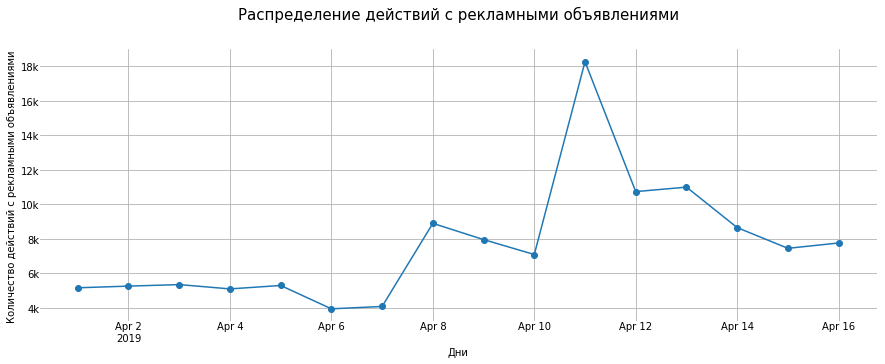

In [4]:
build_plot(dataset)

## Рассмотрим данные только за 11 апреля

In [5]:
cat_dataset = dataset.copy()
cat_columns = cat_dataset.select_dtypes(['object']).columns
mappings = {}
for column in cat_columns:
    mappings[column] = cat_dataset[column].astype('category').cat.categories
cat_dataset[cat_columns] = cat_dataset[cat_columns].apply(lambda x: x.astype('category').cat.codes)

In [6]:
strange_date = Counter(cat_dataset["date"]).most_common(1)[0][0]
new_dataset = cat_dataset[cat_dataset["date"] == strange_date]
new_dataset = new_dataset.drop('date',  axis=1)
new_dataset[['time']] = scaler.fit_transform(new_dataset[['time']])
new_dataset.head(5)

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform
4,0.299895,0,1,0,350,8392,3478,6139,3
16,0.834929,2,0,0,116,8227,12107,17414,0
19,0.812518,2,0,0,116,8228,12109,17441,0
22,0.422205,2,0,0,116,8228,12109,17441,0
25,0.272043,2,0,0,116,8228,12109,17443,0


### Число дублирующихся строк:

In [7]:
print(len(new_dataset) - len(new_dataset.drop_duplicates()))

617


Число дублирующихся строк незначительно, в данных по-прежнему наблюдается всплекс. Удалим дублирующиеся данные.

In [8]:
new_dataset = new_dataset.drop_duplicates()
new_dataset.head(5)

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform
4,0.299895,0,1,0,350,8392,3478,6139,3
16,0.834929,2,0,0,116,8227,12107,17414,0
19,0.812518,2,0,0,116,8228,12109,17441,0
22,0.422205,2,0,0,116,8228,12109,17441,0
25,0.272043,2,0,0,116,8228,12109,17443,0


### Построим гистограмму встречаемости признаков 11 апреля

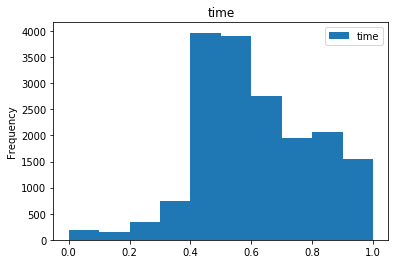

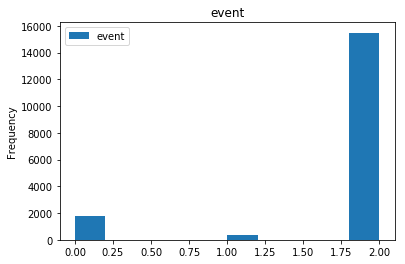

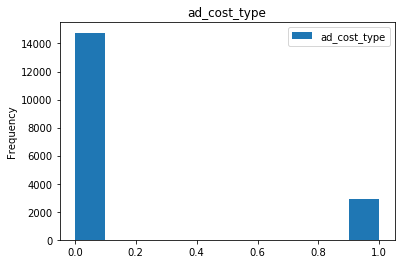

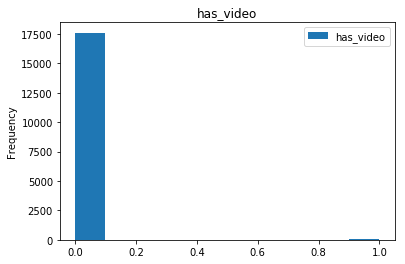

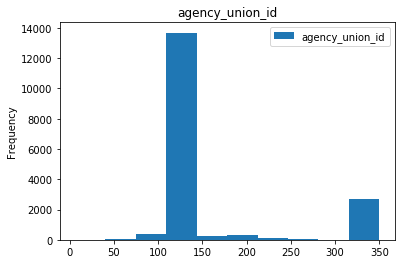

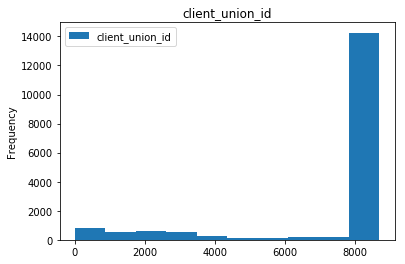

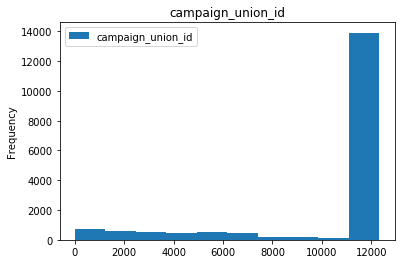

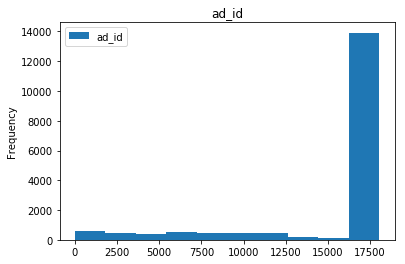

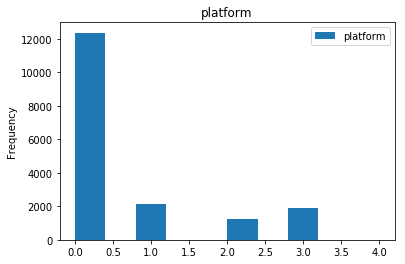

In [9]:
for column in new_dataset.columns:
    new_dataset.plot(y=column, kind='hist', title=column)

Из гистограмм видно, что в этот день произошло какое-то гигансткое количество просмотров одного и того же объявления. Исходя из того, что для этого объявления оплата происходит за 1000 просмотров, можно предположить, что данное рекламное объявление вызвало бурную реакцию у пользователей, которые срочно решили поделиться им со своими друзьями.

In [10]:
most_popular_adv = new_dataset['ad_id'].value_counts().idxmax()
print("Самое популярное объявление за 11 апреля:", mappings['ad_id'][most_popular_adv])

Самое популярное объявление за 11 апреля: ad_49554


Посмотри как измениться график при удалении данного объявления из всех данных: 

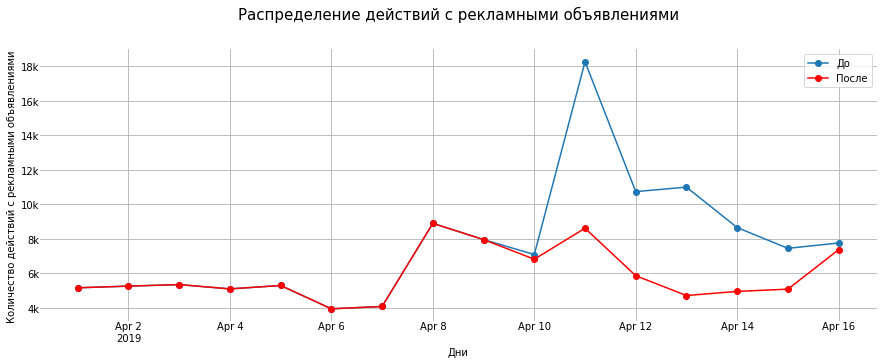

In [11]:
build_plot(dataset, dataset.loc[dataset['ad_id'] != mappings['ad_id'][most_popular_adv]])

### Появление выброса в данных будем отслеживать с помощью критерия Ирвина

Статистика критерия:
$$ s = \frac{|Y_t - T_{t-1}|}{ \sigma} $$

Точка $Y_t$ считается аномальной, если $ s > s_{crit}$.

In [12]:
def irvin_crit(n):
    if n == 2:
        return 2.77
    elif n == 3:
        return 2.17
    return -229.21*(n**(-3)) + 422.39*(n**(-2.5)) -\
            320.96*(n**(-2)) + 124.594*(n**(-1.5)) - \
            26.15*(n**(-1)) + 4.799*(n**(-0.5)) + 0.7029

In [13]:
def irvin_criteria(x, y, n, alpha=0.05, all_prev=False):
    prev = y[:n]
    for i, val in enumerate(y[n:]):
        prev.append(val)
        if not all_prev:
            prev = prev[-n:]
        s = (val - prev[-2]) / np.std(prev, ddof = 1)
        if s > irvin_crit(len(prev)):
            print("Аномалия: ", x[i+n])

### Проверим выбросы для каждого дня
Применим критерий Ирвина для уровня значимости $\alpha$ = 0.05. Наличие выброса будем оценивать по пяти предыдущим дням.

In [14]:
x, y = get_x_y(dataset)
irvin_criteria(x, y, n=5)

Аномалия:  Apr 8
Аномалия:  Apr 11


Наличие выброса будем оценивать, начиная с 3 апреля, по всем предыдущим дням.

In [15]:
irvin_criteria(x, y, n=2, alpha=0.05, all_prev=True)

Аномалия:  Apr 5
Аномалия:  Apr 8
Аномалия:  Apr 11


### Проверим на выбросы каждый час, каждые пять минут данные за 11 апреля. Будем учитывать все предыдущие наблюдения.

In [16]:
df = dataset[dataset["date"] == strange_date]

In [17]:
five_minutes = 300
one_hour = 3600

In [18]:
import datetime 
def irvin_test(df, n, timedelta):
    x = np.arange(df['time'].min(), df['time'].max(), timedelta)  
    x_ = [pair for pair in zip(x[:-1], x[1:])]
    y = [len(df.loc[(df['time'] >= pair[0]) & (df['time'] < pair[1])]) for pair in x_]
    fig = plt.figure(figsize=(20, 7))
    x = [dt.strftime(dt.fromtimestamp(d), '%H:%M') for d in x]
    plt.plot(x[:-1], y, marker='o', c='b')
    ax = plt.gca()
    ax.set_xlabel('Время')
    ax.set_ylabel('Количество действий с рекламными объявлениями')
    ax.set_title('Распределение действий с рекламными объявлениями 11 апреля по часам', fontsize=15, pad=30)
    ax.grid()
    if timedelta == 300:
        ax.xaxis.set_major_locator(IndexLocator(10,1))
        ax.set_title('Распределение действий с рекламными объявлениями 11 апреля по пятиминуткам', fontsize=15, pad=30)
    plt.show()
    prev = y[:n]
    for i, val in enumerate(y[n:]):
        prev.append(val)
        s = (val - prev[-2]) / np.std(prev, ddof=1)
        if s > irvin_crit(len(prev)):
            print("Аномалия: ", x[i+n])

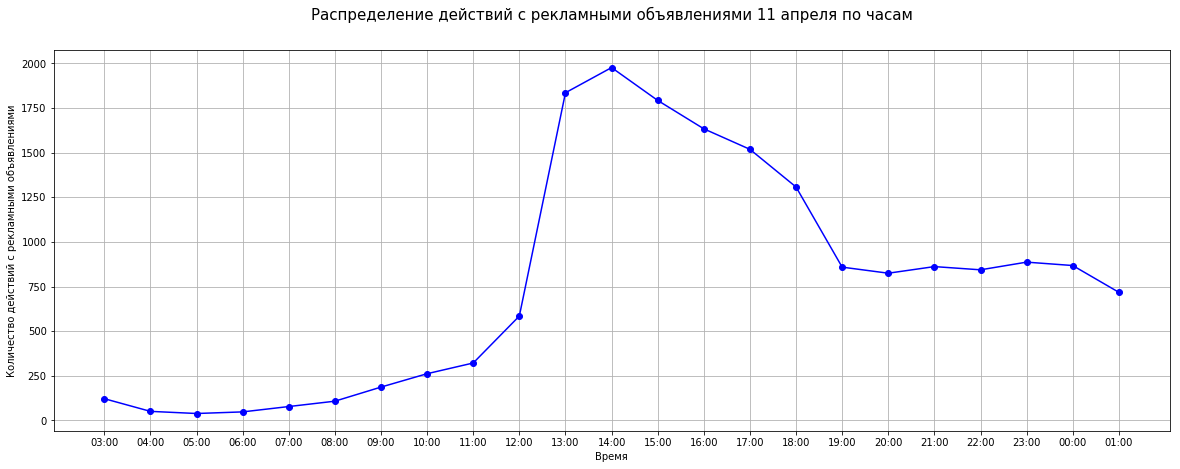

Аномалия:  12:00
Аномалия:  13:00


In [19]:
irvin_test(df, 5, one_hour)

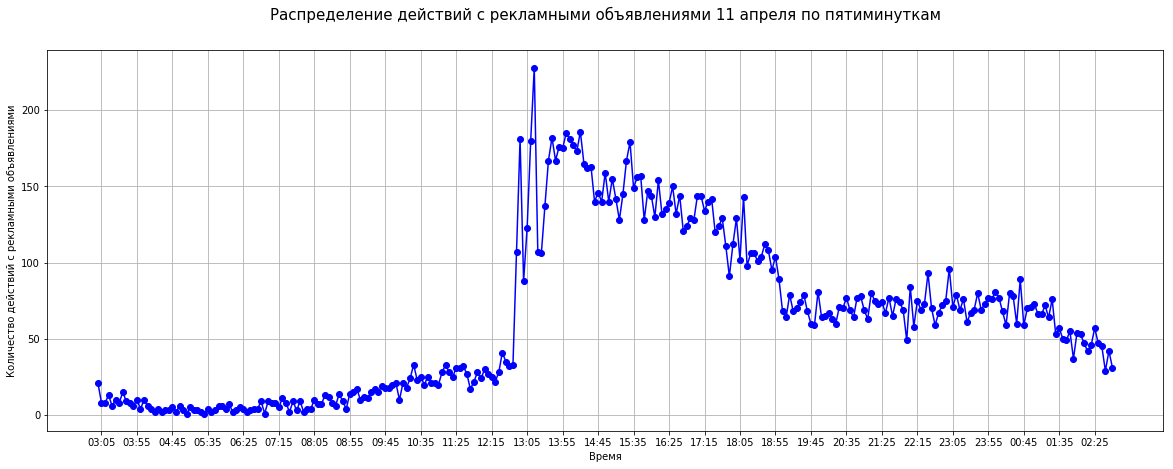

Аномалия:  06:50
Аномалия:  07:00
Аномалия:  07:20
Аномалия:  07:35
Аномалия:  07:45
Аномалия:  08:05
Аномалия:  08:20
Аномалия:  08:40
Аномалия:  08:55
Аномалия:  10:10
Аномалия:  10:20
Аномалия:  10:25
Аномалия:  11:05
Аномалия:  12:30
Аномалия:  12:50
Аномалия:  12:55
Аномалия:  13:05
Аномалия:  13:10
Аномалия:  13:15


In [20]:
irvin_test(df, 20, five_minutes)